# Summary

Here are the two things I wanted to share:
1. [Labels](#labels) : What are the labels in this competitions and how they are related to one another
2. [Music](#music) : How musical scales work and an example of analysis on sample from electric guitare

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import librosa
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import IPython.display as ipd

# Any results you write to the current directory are saved as output.

# Labels
First import and have a look at labels

In [4]:
meta = pd.read_csv("../input/train_curated.csv",sep=",")
meta.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [5]:
meta.shape

(4970, 2)

In [6]:
meta.labels.value_counts()

Gong                                                                                       75
Zipper_(clothing)                                                                          75
Marimba_and_xylophone                                                                      75
Keys_jangling                                                                              75
Finger_snapping                                                                            75
Printer                                                                                    75
Computer_keyboard                                                                          75
Skateboard                                                                                 75
Scissors                                                                                   75
Fart                                                                                       74
Burping_and_eructation                                      

Some samples can have multiples classes (for example *tap* that goes with *bass_drum*), let's create a dataframe can be easily used for training and for data exploration of the different classes.

In [8]:
labels = meta.labels.str.split(",",expand=True)
labels.head()

,0,1,2,3,4,5
0,Bark,None,None,None,None,None
1,Raindrop,None,None,None,None,None
2,Finger_snapping,None,None,None,None,None
3,Run,None,None,None,None,None
4,Finger_snapping,None,None,None,None,None


At most 5 different labels can appear in a single audio file. Let's do one-hot encoding of each sample:

In [9]:
labels_onehot = pd.get_dummies(labels.loc[:,0])

In [10]:
labels_onehot.shape

(4970, 78)

78 categories are available in just the first column (not sure if the order labels appear has any kind of importance).
Next we:
- create a column if a label has never been seen before
- set to 1 the samples where the label is found 

In [11]:
for i in range(1, labels.shape[1]):
    for lab in labels.loc[:,i].unique():
        if lab is not None:
            if not lab in list(labels_onehot):
                print(lab)
                labels_onehot[lab] = 0
            labels_onehot.loc[labels.loc[:,i]==lab,lab] = 1

Strum
Water_tap_and_faucet


Two labels had never been seen before: *Strum* & *Water_tap_and_faucet*. How often do they appear?

In [12]:
labels_onehot[["Strum","Water_tap_and_faucet"]].sum(axis=0)

Strum                   75
Water_tap_and_faucet    75
dtype: int64

So each of them appear 75 times, but they always appear with at least one other label. Given the first letter, we can assume that the labels are sorted by alphabetical order when there are multiple labels in a sample.

In [13]:
labels_onehot.sum(axis=0)

Accelerating_and_revving_and_vroom    75
Accordion                             47
Acoustic_guitar                       75
Applause                              75
Bark                                  75
Bass_drum                             75
Bass_guitar                           75
Bathtub_(filling_or_washing)          75
Bicycle_bell                          67
Burping_and_eructation                75
Bus                                   75
Buzz                                  56
Car_passing_by                        75
Cheering                              75
Chewing_and_mastication               75
Child_speech_and_kid_speaking         75
Chink_and_clink                       75
Chirp_and_tweet                       75
Church_bell                           75
Clapping                              75
Computer_keyboard                     75
Crackle                               75
Cricket                               75
Crowd                                 75
Cupboard_open_or

Each sound seems to be almost evenly distributed with ~ 70 samples of each label (with many having exactly 75 samples)
What are the co-labels?

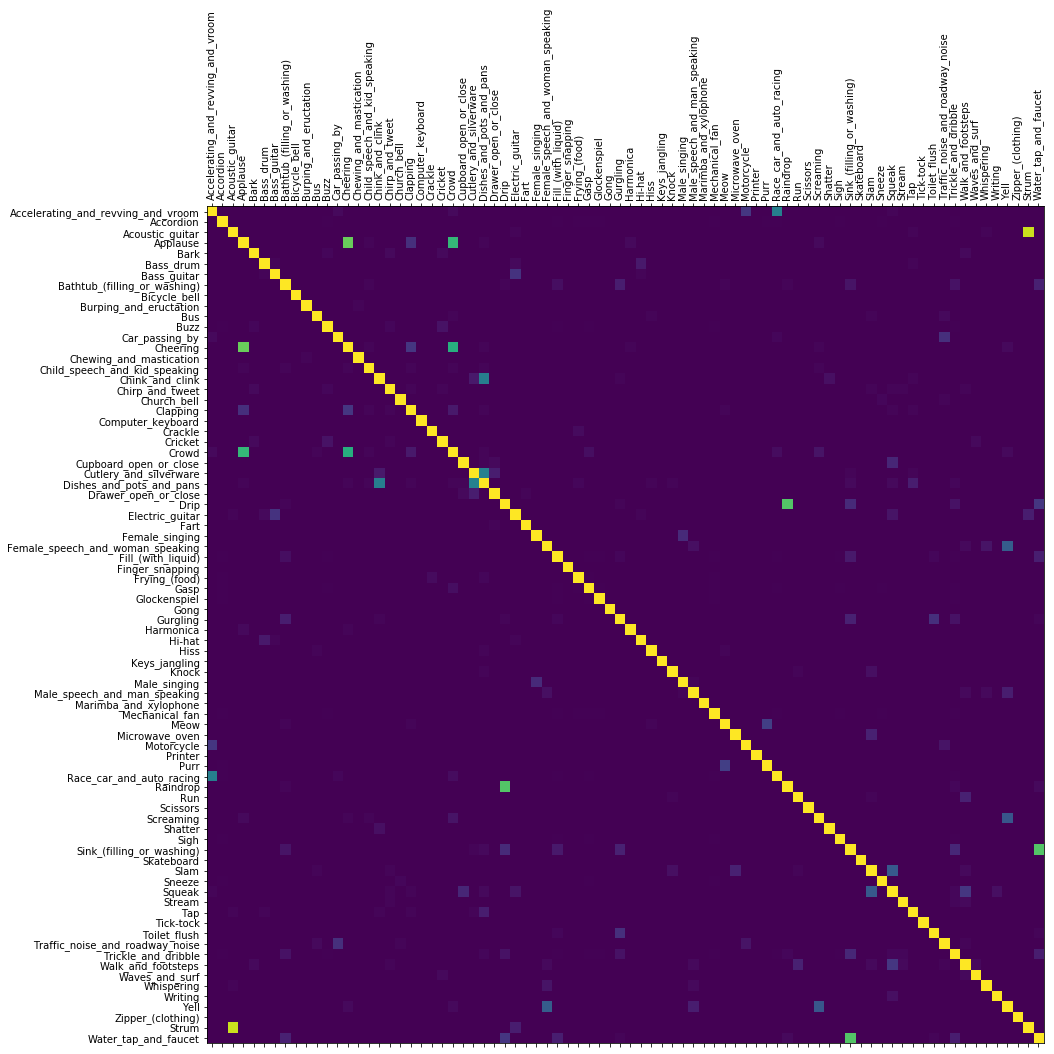

In [14]:
plt.figure(figsize=(15,15))
plt.matshow(labels_onehot.corr(),fignum=1)
plt.xticks(range(len(labels_onehot.columns)), labels_onehot.columns, rotation='vertical');
plt.yticks(range(len(labels_onehot.columns)), labels_onehot.columns);
plt.show()

Multiclasses are not random, only a little number of classes co-occur like crows cheering and applauding or strum and acoustic guitar. This makes sense as you would not expect a computer keyboard sound in the middle of a car race!

# Music

I've been passionate about music, so here is a basic knowledge of how musical scales work nowadays (it changed during time, and it differs between cultures, but it does not matter for this competition).

The reference key is A (La in french) and has a frequency of 440 Hz. If you want to obtain the same note at a higher pitch (called an octave or scale), you double the frequency. If you want to have a lower pitch you divide the frequency by 2.

## Why is that important?
Except for the dial tone (the one you heard when you picked up phones when I was young), no musical instrument is giving you a perfect 440Hz. However, what you get is a combination of this note and its harmonics (octaves). So a musical instrument should have a very clear pattern of doubled frequency.

## How do we go from one note to another?
There isn't only a single note in a scale, and once again, the patterns for going between a note and the next one is very codified.
Once you have your scale, you divide it in **12 semitones**. As you're good with maths, you'll notice that 12 does not perfectly divide 440Hz, and this is where the magic of music lies: hiding this dissonance somewhere (and this is why scales have changed over time).

Let's see if we can observe these patterns in the data

Here are some curated *Electric_guitar* filenames:

In [15]:
meta.loc[labels_onehot.Electric_guitar == 1,"fname"].head()

55     03730245.wav
105    06396c9c.wav
155    084a8851.wav
189    0a9bebde.wav
224    0c0fdf50.wav
Name: fname, dtype: object

Since this is music, let's listen to it!

In [16]:
ipd.Audio(wavfile.read("../input/train_curated/03730245.wav")[1], rate=44100)

This is a single note played at quite low resolution (whether because the instruments are bad or the recording microphones or compression...)

What does it look like?

In [17]:
sampling, audio = wavfile.read("../input/train_curated/03730245.wav")

Text(90000, -25000, 'Muting')

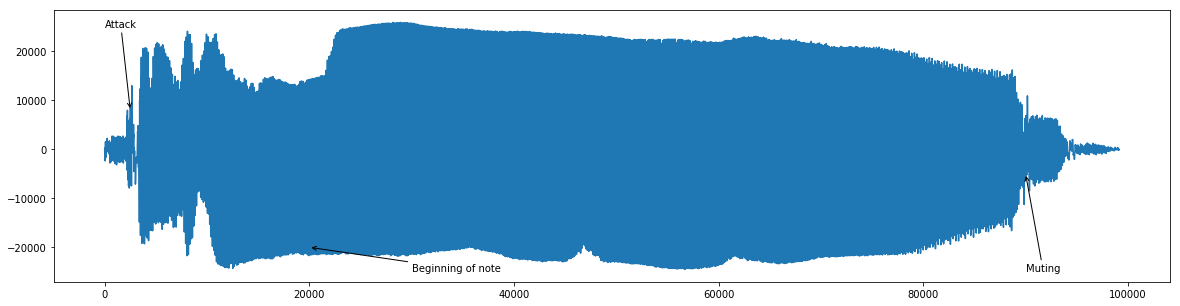

In [18]:
plt.figure(figsize = (20,5))
plt.plot(audio)
plt.annotate("Attack",(2500,8000),(0,25000), arrowprops = {"arrowstyle":"->"})
plt.annotate("Beginning of note",(20000,-20000),(30000,-25000), arrowprops = {"arrowstyle":"->"})
plt.annotate("Muting",(90000,-5000),(90000,-25000), arrowprops = {"arrowstyle":"->"})


Since this is pretty messy (oscillations cannot be observed easily on this plot), let's swith to a spectrogram representation.

In [19]:
y, sr = librosa.load("../input/train_curated/03730245.wav")
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
mel_spec.shape

(128, 97)

In [21]:
# since specshow does not seem to work from librosa library, just copying it from : https://github.com/librosa/librosa/blob/master/librosa/display.py
from matplotlib.cm import get_cmap
from matplotlib.axes import Axes
from matplotlib.ticker import Formatter, ScalarFormatter
from matplotlib.ticker import LogLocator, FixedLocator, MaxNLocator
from matplotlib.ticker import SymmetricalLogLocator

def specshow(data, x_coords=None, y_coords=None,
             x_axis=None, y_axis=None,
             sr=22050, hop_length=512,
             fmin=None, fmax=None,
             bins_per_octave=12,
             ax=None,
            **kwargs):
    if np.issubdtype(data.dtype, np.complexfloating):
        warnings.warn('Trying to display complex-valued input. '
                      'Showing magnitude instead.')
        data = np.abs(data)
    kwargs.setdefault('cmap', cmap(data))
    kwargs.setdefault('rasterized', True)
    kwargs.setdefault('edgecolors', 'None')
    kwargs.setdefault('shading', 'flat')
    all_params = dict(kwargs=kwargs,
                      sr=sr,
                      fmin=fmin,
                      fmax=fmax,
                      bins_per_octave=bins_per_octave,
                      hop_length=hop_length)
    # Get the x and y coordinates
    y_coords = __mesh_coords(y_axis, y_coords, data.shape[0], **all_params)
    x_coords = __mesh_coords(x_axis, x_coords, data.shape[1], **all_params)
    axes = __check_axes(ax)
    out = axes.pcolormesh(x_coords, y_coords, data, **kwargs)
    __set_current_image(ax, out)
    axes.set_xlim(x_coords.min(), x_coords.max())
    axes.set_ylim(y_coords.min(), y_coords.max())
    # Set up axis scaling
    __scale_axes(axes, x_axis, 'x')
    __scale_axes(axes, y_axis, 'y')
    # Construct tickers and locators
    __decorate_axis(axes.xaxis, x_axis)
    __decorate_axis(axes.yaxis, y_axis)
    return axes

def __set_current_image(ax, img):
    plt.sci(img)

    
def __mesh_coords(ax_type, coords, n, **kwargs):
    if coords is not None:
        if len(coords) < n:
            raise ParameterError('Coordinate shape mismatch: '
                                 '{}<{}'.format(len(coords), n))
        return coords

    coord_map = {
                 'mel': __coord_mel_hz,
                 None: __coord_n}

    if ax_type not in coord_map:
        raise ParameterError('Unknown axis type: {}'.format(ax_type))
    return coord_map[ax_type](n, **kwargs)


def __check_axes(axes):
    '''Check if "axes" is an instance of an axis object. If not, use `gca`.'''
    if axes is None:
        import matplotlib.pyplot as plt
        axes = plt.gca()
    elif not isinstance(axes, Axes):
        raise ValueError("`axes` must be an instance of matplotlib.axes.Axes. "
                         "Found type(axes)={}".format(type(axes)))
    return axes


def __scale_axes(axes, ax_type, which):
    '''Set the axis scaling'''

    kwargs = dict()
    if which == 'x':
        thresh = 'linthreshx'
        base = 'basex'
        scale = 'linscalex'
        scaler = axes.set_xscale
        limit = axes.set_xlim
    else:
        thresh = 'linthreshy'
        base = 'basey'
        scale = 'linscaley'
        scaler = axes.set_yscale
        limit = axes.set_ylim

    # Map ticker scales
    if ax_type == 'mel':
        mode = 'symlog'
        kwargs[thresh] = 1000.0
        kwargs[base] = 2

    elif ax_type == 'log':
        mode = 'symlog'
        kwargs[base] = 2
        kwargs[thresh] = core.note_to_hz('C2')
        kwargs[scale] = 0.5

    elif ax_type in ['cqt', 'cqt_hz', 'cqt_note']:
        mode = 'log'
        kwargs[base] = 2

    elif ax_type == 'tempo':
        mode = 'log'
        kwargs[base] = 2
        limit(16, 480)
    else:
        return

    scaler(mode, **kwargs)


def __decorate_axis(axis, ax_type):
    '''Configure axis tickers, locators, and labels'''

    if ax_type == 'tonnetz':
        axis.set_major_formatter(TonnetzFormatter())
        axis.set_major_locator(FixedLocator(0.5 + np.arange(6)))
        axis.set_label_text('Tonnetz')

    elif ax_type == 'chroma':
        axis.set_major_formatter(ChromaFormatter())
        axis.set_major_locator(FixedLocator(0.5 +
                                            np.add.outer(12 * np.arange(10),
                                                         [0, 2, 4, 5, 7, 9, 11]).ravel()))
        axis.set_label_text('Pitch class')

    elif ax_type == 'tempo':
        axis.set_major_formatter(ScalarFormatter())
        axis.set_major_locator(LogLocator(base=2.0))
        axis.set_label_text('BPM')

    elif ax_type == 'time':
        axis.set_major_formatter(TimeFormatter(unit=None, lag=False))
        axis.set_major_locator(MaxNLocator(prune=None,
                                           steps=[1, 1.5, 5, 6, 10]))
        axis.set_label_text('Time')

    elif ax_type == 's':
        axis.set_major_formatter(TimeFormatter(unit='s', lag=False))
        axis.set_major_locator(MaxNLocator(prune=None,
                                           steps=[1, 1.5, 5, 6, 10]))
        axis.set_label_text('Time (s)')

    elif ax_type == 'ms':
        axis.set_major_formatter(TimeFormatter(unit='ms', lag=False))
        axis.set_major_locator(MaxNLocator(prune=None,
                                           steps=[1, 1.5, 5, 6, 10]))
        axis.set_label_text('Time (ms)')

    elif ax_type == 'lag':
        axis.set_major_formatter(TimeFormatter(unit=None, lag=True))
        axis.set_major_locator(MaxNLocator(prune=None,
                                           steps=[1, 1.5, 5, 6, 10]))
        axis.set_label_text('Lag')

    elif ax_type == 'lag_s':
        axis.set_major_formatter(TimeFormatter(unit='s', lag=True))
        axis.set_major_locator(MaxNLocator(prune=None,
                                           steps=[1, 1.5, 5, 6, 10]))
        axis.set_label_text('Lag (s)')

    elif ax_type == 'lag_ms':
        axis.set_major_formatter(TimeFormatter(unit='ms', lag=True))
        axis.set_major_locator(MaxNLocator(prune=None,
                                           steps=[1, 1.5, 5, 6, 10]))
        axis.set_label_text('Lag (ms)')

    elif ax_type == 'cqt_note':
        axis.set_major_formatter(NoteFormatter())
        axis.set_major_locator(LogLocator(base=2.0))
        axis.set_minor_formatter(NoteFormatter(major=False))
        axis.set_minor_locator(LogLocator(base=2.0,
                                          subs=2.0**(np.arange(1, 12)/12.0)))
        axis.set_label_text('Note')

    elif ax_type in ['cqt_hz']:
        axis.set_major_formatter(LogHzFormatter())
        axis.set_major_locator(LogLocator(base=2.0))
        axis.set_minor_formatter(LogHzFormatter(major=False))
        axis.set_minor_locator(LogLocator(base=2.0,
                                          subs=2.0**(np.arange(1, 12)/12.0)))
        axis.set_label_text('Hz')

    elif ax_type in ['mel', 'log']:
        axis.set_major_formatter(ScalarFormatter())
        axis.set_major_locator(SymmetricalLogLocator(axis.get_transform()))
        axis.set_label_text('Hz')

    elif ax_type in ['linear', 'hz']:
        axis.set_major_formatter(ScalarFormatter())
        axis.set_label_text('Hz')

    elif ax_type in ['frames']:
        axis.set_label_text('Frames')

    elif ax_type in ['off', 'none', None]:
        axis.set_label_text('')
        axis.set_ticks([])


def __coord_fft_hz(n, sr=22050, **_kwargs):
    n_fft = 2 * (n - 1)
    # The following code centers the FFT bins at their frequencies
    # and clips to the non-negative frequency range [0, nyquist]
    basis = core.fft_frequencies(sr=sr, n_fft=n_fft)
    fmax = basis[-1]
    basis -= 0.5 * (basis[1] - basis[0])
    basis = np.append(np.maximum(0, basis), [fmax])
    return basis


def __coord_mel_hz(n, fmin=0, fmax=11025.0, **_kwargs):
    '''Get the frequencies for Mel bins'''

    if fmin is None:
        fmin = 0
    if fmax is None:
        fmax = 11025.0
    basis = librosa.mel_frequencies(n, fmin=fmin, fmax=fmax)
    basis[1:] -= 0.5 * np.diff(basis)
    basis = np.append(np.maximum(0, basis), [fmax])
    return basis

def cmap(data, robust=True, cmap_seq='magma', cmap_bool='gray_r', cmap_div='coolwarm'):
    data = np.atleast_1d(data)

    if data.dtype == 'bool':
        return get_cmap(cmap_bool)

    data = data[np.isfinite(data)]

    if robust:
        min_p, max_p = 2, 98
    else:
        min_p, max_p = 0, 100

    max_val = np.percentile(data, max_p)
    min_val = np.percentile(data, min_p)

    if min_val >= 0 or max_val <= 0:
        return get_cmap(cmap_seq)

    return get_cmap(cmap_div)

def __coord_n(n, **_kwargs):
    '''Get bare positions'''
    return np.arange(n+1)

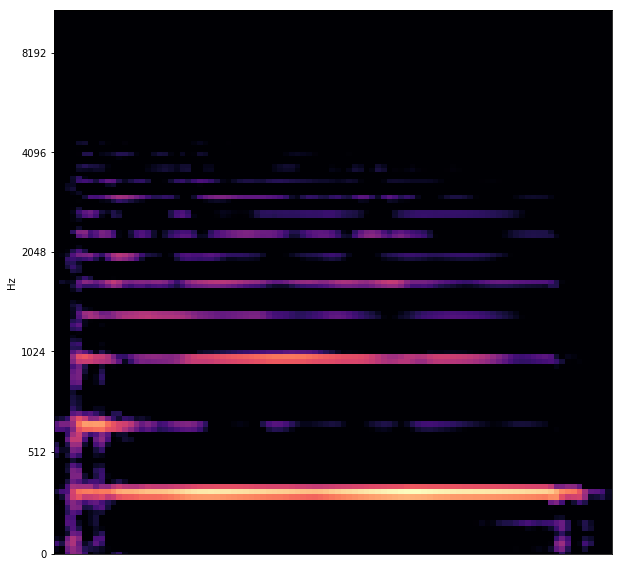

In [22]:

D = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(10,10))
specshow(D, x_coords=None, y_coords=None,
             x_axis=None, y_axis="mel",
             sr=sr, hop_length=512,
             fmin=None, fmax=None,
             bins_per_octave=12,
             ax=None
            )

We can see the harmonicity here: the base note has highest amplitude, then all harmonics have decreasing amplitudes. 
Also the attack and muting add noise, as it requires a lot of sinusoidal signals to go from 0 to periodic (and reverse), this is due to the fourier transformation.

Feel free to suggest improvements to this kernel, and if you're interested in musical scales construction I suggest you have a look at this video (which is much more complete than this kernel):
https://www.youtube.com/watch?v=cTYvCpLRwao (audio is in french, but there are some english subtitles).